In [1]:
# ===============
# To make baseline skill metrics to compare our analogue system against
# ===============

import numpy as np
import xarray as xr
import glob
import pickle
import os
import matplotlib.pyplot as plt
from scipy import stats
import time
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import sys
import getpass
sys.path.insert(0, '/home/users/lfbor/python/scripts3/python_modules')
from analogue import *
import mfilter

usr = getpass.getuser()
data_dir = '/home/users/{}/data'.format(usr)
figure_dir = '/home/users/{}/python/output_figures/'.format(usr)
scripts_dir = '/home/users/{}/python/scripts3/'.format(usr)

print(data_dir)

%matplotlib inline

/home/users/lfbor/data


In [2]:
# ===============
# Hindcast models with the most members
# ===============
hind_models_most_members = ['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6',
                            'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']

# ===============
# Equivalent historical models
# ===============
hist_models_most_members = hind_models_most_members[:]
hist_models_most_members.remove('CanCM4')
hist_models_most_members += ['CanESM2']

print(hind_models_most_members)
print(hist_models_most_members)

# ===============
# Target (truth) variable
# ===============
var = 'SST'

# ===============
# Target (truth) region
# ===============
target_region = 'subpolar_gyre'
# target_region = 'north_atlantic'
# target_region = 'europe1'

['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']
['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'IPSL-CM6A-LR', 'bcc-csm1-1', 'CanESM2']


In [3]:
max_lead = 11
lead_times = np.arange(max_lead)  # Including a lead time of zero (i.e. the input correlation)

if var == 'SST':
    obs_save_file = '{:s}/HadISST_time_series_regions.pkl'.format(data_dir)
    mpi = True
elif var == 'SAT':
    obs_save_file = '{:s}/HadCRUT4_time_series_regions.pkl'.format(data_dir)
    mpi = True
elif var == 'DepthAverageT':
    obs_save_file = '{:s}/EN4_0-500m_time_series_regions.pkl'.format(data_dir)
    mpi = False
else:
    raise ValueError('Unknown variable')
    
cmip5_list_file = os.path.join(scripts_dir, 'model_lists/cmip5_list.txt')
cmip6_list_file = os.path.join(scripts_dir, 'model_lists/cmip6_list.txt')

cmip5_models = []
with open(cmip5_list_file, 'r') as f:
    for line in f.readlines():
        cmip5_models.append(line.strip())

cmip6_models = []
with open(cmip6_list_file, 'r') as f:
    for line in f.readlines():
        cmip6_models.append(line.strip())

In [4]:
# =====================
# This is NOT for the analogues/skill, just for the baseline skill scores
# =====================
input_save_file = '{:s}/HistoricalAnalogues_Inputs_{:s}.pkl'.format(data_dir, var)
if os.path.isfile(input_save_file):
    with open(input_save_file, 'rb') as handle:
        print("Loading save file: {:s}".format(input_save_file))
        stored_data = pickle.load(handle, encoding='latin')
        print(" == Complete")
else:
    raise ValueError("This is created in a script now (AnalogueCache.py)")

Loading save file: /home/users/lfbor/data/HistoricalAnalogues_Inputs_SST.pkl
 == Complete


In [5]:
# Read the real historical data for validation
with open(obs_save_file, 'rb') as handle:
    print("Loading save file: {:s}".format(obs_save_file))
    # Slightly different shape to the models (no spatial info)
    _, sst_ts_ann, _, year_ann = pickle.load(handle, encoding='latin')
    nyrs = len(year_ann)
    
    # This should probably also be in a class, but I don't know how yet
    target_time_series = sst_ts_ann[target_region]
    print(" == Complete")

Loading save file: /home/users/lfbor/data/HadISST_time_series_regions.pkl
 == Complete


In [6]:
# Read the MPI SPECS data with hindcasts back to 1900 and put into the same shape array (take multi-ens mean)
if mpi:
    mpi_long_save = '{:s}/MPI_LongHinds_{:s}_TimeSeries.pkl'.format(data_dir, var)
    with open(mpi_long_save, 'rb') as handle:
        mpi_longhinds_in, mpi_years = pickle.load(handle, encoding='latin')
        mpi_longhinds_in = mpi_longhinds_in[target_region]
        print(mpi_longhinds_in.shape)
        nmpi_mems, _, nmpi_leads = mpi_longhinds_in.shape

    print('MPI:    ', mpi_years[0], mpi_years[-1])

    t0 = np.argwhere(year_ann == mpi_years[0])[0][0]
    t1 = np.argwhere(year_ann == mpi_years[-1])[0][0] + 1

    mpi_longhinds = np.ma.masked_all(shape=(nmpi_mems, nyrs, nmpi_leads))
    for imem in range(nmpi_mems):
        for ilead in range(nmpi_leads):
            mpi_longhinds[imem, t0:t1, ilead] = mpi_longhinds_in[imem, :, ilead]
    mpi_longhinds_ensmn = mpi_longhinds.mean(axis=0)

print('Obs: ', year_ann[0], year_ann[-1])


(3, 110, 11)
MPI:     1900 2009
Obs:  1870 2019


In [7]:
# =======================
# Functions to help processing the historical/hindcast data
# =======================
tol = 0.9

def anomalise3d(in_arr, t0, t1, tol=0.9):
    ni, nj, nt = in_arr.shape
    mn = in_arr[:, :, t0:t1].mean(axis=2)
    mn = np.repeat(mn[:, :, None], nt, axis=2)
    out = in_arr - mn
    for ii in range(ni):
        for jj in range(nj):
            if np.ma.count(in_arr[ii, jj, t0:t1]) < ((t1-t0) * tol):
                out[ii, jj, :].mask = True
    return out

# Inflated variance version:
def inflate3d(in_arr, target_std, t0, t1):
    _, _, nt = in_arr.shape
    mn3d = np.repeat(np.ma.mean(in_arr[:, :, t0:t1], axis=2)[:, :, None], nt, axis=2)
    in_arr_anom = anomalise3d(in_arr, t0, t1, tol=0.9)
    std3d = np.repeat(np.ma.std(in_arr[:, :, t0:t1], axis=2)[:, :, None], nt, axis=2)
    out = in_arr_anom * (target_std / std3d) + mn3d
    return out

Finding historical simulations in STORED_DATA
Computing historical averages
140279746350592 140279746352960
9


/opt/jaspy/lib/python3.8/site-packages/numpy/ma/core.py:4283: RuntimeWarning: invalid value encountered in multiply
  self._data.__imul__(np.where(self._mask, self.dtype.type(1),
/tmp/ipykernel_509/2604515316.py:23: RuntimeWarning: divide by zero encountered in true_divide
  out = in_arr_anom * (target_std / std3d) + mn3d


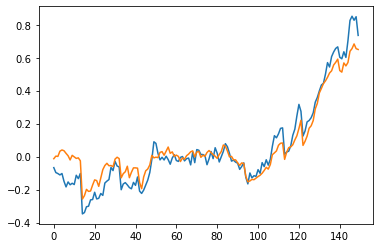

In [8]:
# =======================
# Historical simulations (not analogue approach)
# First have to get the data...
print("Finding historical simulations in STORED_DATA")
hist_models = []
for ii, record in enumerate(stored_data):
    if record.experiment == 'historical':
        hist_models.append(record.model)
hist_models = list(set(hist_models))
historical_time_series = np.ma.masked_all(shape=(len(hist_models), 10, len(year_ann)))

for irec, record in enumerate(stored_data):
    if not ((record.sub_var == target_region) and (record.var == var)):
        continue
    if not ((record.experiment == 'historical') or (record.experiment == 'rcp85') or (record.experiment == 'ssp585')):
        continue
    if record.model not in hist_models:
        # This could happen if it is future data
        continue
    
    imodel = hist_models.index(record.model)
    iens  = record.ens_mem - 1
    
    for tt_out, year in enumerate(year_ann):
        if year in record.time:
            tt_in = np.argwhere(record.time == year)[0][0]
            historical_time_series[imodel, iens, tt_out] = record.time_series[tt_in]

print("Computing historical averages")
t0 = np.argwhere(year_ann == 1900)[0][0]
t1 = np.argwhere(year_ann == 2000)[0][0]
historical_time_series_anom = anomalise3d(historical_time_series, t0, t1, tol=0.9)
historical_time_series_anom_ensmn = np.ma.mean(historical_time_series_anom, axis=1)
historical_time_series_anom_ensmn_mmm = np.ma.mean(historical_time_series_anom_ensmn, axis=0)

t0 = np.argwhere(year_ann == 1870)[0][0]
t1 = np.argwhere(year_ann == 2005)[0][0]

historical_time_series_anom_inf = inflate3d(historical_time_series_anom, target_time_series[t0:t1].std(), t0, t1)
historical_time_series_anom_inf_ensmn = np.ma.mean(historical_time_series_anom_inf, axis=1)
historical_time_series_anom_inf_ensmn_mmm = np.ma.mean(historical_time_series_anom_inf_ensmn, axis=0)

# Change this to the hind subset
histsub_models = ['IPSL-CM6A-LR', 'CNRM-CM5', 'MIROC5', 'CanESM2', 'FGOALS-g2', 'CanESM5', 'CMCC-CM', 'MIROC6', 'NorCPM1', 'EC-EARTH', 'MPI-ESM-MR', 'MRI-CGCM3', 'MPI-ESM-LR', 'bcc-csm1-1', 'GFDL-CM2p1']
histsub_models = hist_models_most_members[:]
print(id(histsub_models), id(hist_models_most_members))

indhistsub = []
for imodel, model in enumerate(hist_models):
    if model in histsub_models:
        indhistsub.append(imodel)
print(len(indhistsub))
        
historical_time_series_anom_ensmn_mmmsub = np.ma.mean(historical_time_series_anom_ensmn[indhistsub, :], axis=0)

plt.plot(historical_time_series_anom_ensmn_mmmsub)
plt.plot(historical_time_series_anom_ensmn_mmm)

In [9]:
# =======================
# Hindcast simulations (not analogue approach)
# First have to get the data...
print("Finding hindcast simulations in STORED_DATA")
hind_models = []
start_dates = []
hind_models_cm5, hind_models_cm6, start_dates_cm5, start_dates_cm6 = [], [], [], []
for ii, record in enumerate(stored_data):
    if record.experiment[:7] == 'decadal':
        if record.model not in hind_models_most_members:
            # MAJOR EDIT: Ignore models without many start dates
            continue
        hind_models.append(record.model)
        start_dates.append(np.long(record.experiment[7:]))
        if record.project == 'CMIP5':
            hind_models_cm5.append(record.model)
            start_dates_cm5.append(np.long(record.experiment[7:]))
        elif record.project == 'CMIP6':
            hind_models_cm6.append(record.model)
            start_dates_cm6.append(np.long(record.experiment[7:]))
        else:
            raise ValueError('Unknown project')
hind_models = list(set(hind_models))
hind_models_cm5 = list(set(hind_models_cm5))
hind_models_cm6 = list(set(hind_models_cm6))
nhind_models = len(hind_models)
start_dates = np.sort(np.array(list(set(start_dates))))
nstart_dates = start_dates.shape[0]

nens_mems = 10
n_hind_lead_times = 11  # We add 1 because 0 is lead=0 (which doesn't exist in hindcasts)

hindcast_time_series = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))
hindcast_time_series_cm5 = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))
hindcast_time_series_cm6 = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))

unfull_models = []
for irec, record in enumerate(stored_data):
    if record.model not in hind_models_most_members:
        # MAJOR EDIT: Ignore models without many start dates
        continue
    if not ((record.experiment[:7] == 'decadal') and (record.sub_var == target_region) and (record.var == var)):
        continue
#     if record.model == 'IPSL-CM5A-LR': continue
        
#     if record.model == 'NorCPM1':  continue
        
#     if record.model == 'CanESM5':  continue  # Removed on Leo's advice due to errors in init in SPG
    
    imodel = hind_models.index(record.model)
    iens  = record.ens_mem - 1
    start_year = np.long(record.experiment[7:])
    istart_year = start_year - year_ann[0]
    
    # For each model/ens-mem, for the decadal init. year, put all the lead time data in
    for jj, year in enumerate(record.time):
        if (year - start_year) > 10: continue
        jj2 = year - start_year
        if jj2 == 0:
            unfull_models.append(record.model)
#             print "{:s}: This shouldn't exist, and if it does it's probably because there is an unfull annual mean".format(record.model)
            continue
        hindcast_time_series[imodel, iens, istart_year, jj2] = record.time_series[jj]
        if record.project == 'CMIP5':
            hindcast_time_series_cm5[imodel, iens, istart_year, jj2] = record.time_series[jj]
        elif record.project == 'CMIP6':
            hindcast_time_series_cm6[imodel, iens, istart_year, jj2] = record.time_series[jj]
print('Unfull models: ', set(unfull_models))
    
hindcast_time_series_ensmn = np.ma.mean(hindcast_time_series, axis=1)
hindcast_time_series_ensmn_mmm = np.ma.mean(hindcast_time_series_ensmn, axis=0)

hindcast_time_series_ensmn_cm5 = np.ma.mean(hindcast_time_series_cm5, axis=1)
hindcast_time_series_ensmn_mmm5 = np.ma.mean(hindcast_time_series_ensmn_cm5, axis=0)
hindcast_time_series_ensmn_cm6 = np.ma.mean(hindcast_time_series_cm6, axis=1)
hindcast_time_series_ensmn_mmm6 = np.ma.mean(hindcast_time_series_ensmn_cm6, axis=0)

# def lead_time_bias_correction(hindcast_time_series_ensmn):
#     ndim = hindcast_time_series_ensmn.ndim
#     if ndim == 2:  # MMM
#         print 'Bias correcting MMM'
#         lead_time_bias = np.ma.mean(hindcast_time_series_ensmn, axis=0)
#         bias_corrected = hindcast_time_series_ensmn - lead_time_bias[None, :]  # Broadcast these together
#     elif ndim == 3:  # First dim is model
#         print 'Bias correcting all models'
#         lead_time_bias = np.ma.mean(hindcast_time_series_ensmn, axis=1)
#         bias_corrected = hindcast_time_series_ensmn - lead_time_bias[:, None, :]  # Broadcast these together
#     return bias_corrected

hindcast_time_series_ensmn_ltbc = lead_time_bias_correction(hindcast_time_series_ensmn)
hindcast_time_series_ensmn_ltbc_mmm = np.ma.mean(hindcast_time_series_ensmn_ltbc, axis=0)

hindcast_time_series_ensmn_ltbc_cm5 = lead_time_bias_correction(hindcast_time_series_ensmn_cm5)
hindcast_time_series_ensmn_ltbc_mmm5 = np.ma.mean(hindcast_time_series_ensmn_ltbc_cm5, axis=0)
hindcast_time_series_ensmn_ltbc_cm6 = lead_time_bias_correction(hindcast_time_series_ensmn_cm6)
hindcast_time_series_ensmn_ltbc_mmm6 = np.ma.mean(hindcast_time_series_ensmn_ltbc_cm6, axis=0)

print(hindcast_time_series.shape)
print(hindcast_time_series_ensmn.shape)
print(hindcast_time_series_ensmn_mmm.shape)

nmodels_with_this_start_date = nhind_models - np.ma.count_masked(hindcast_time_series_ensmn[:, :, 1], axis=0)


Finding hindcast simulations in STORED_DATA


/tmp/ipykernel_509/1872006087.py:14: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_dates.append(np.long(record.experiment[7:]))
/tmp/ipykernel_509/1872006087.py:20: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` fo

Unfull models:  {'GFDL-CM2p1', 'NorCPM1', 'MIROC6'}
Bias correcting all models
Bias correcting all models
Bias correcting all models
(10, 10, 150, 11)
(10, 150, 11)
(150, 11)


In [10]:
print(start_dates)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [11]:
print(hind_models)
print(hind_models_cm5)
print(hind_models_cm6)

['NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MPI-ESM-LR', 'MIROC6', 'MIROC5', 'GEOS-5', 'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']
['GFDL-CM2p1', 'MPI-ESM-LR', 'MIROC5', 'GEOS-5', 'CanCM4', 'bcc-csm1-1']
['CanESM5', 'NorCPM1', 'IPSL-CM6A-LR', 'MIROC6']


In [12]:
# =======================
# Compute some baseline measures of skill (to beat)
# =======================
nlead = 11
start_lead = [1, 2, 3, 4, 5, 6,  1,  2]  # For the multiannual skill
end_lead =   [5, 6, 7, 8, 9, 10, 10, 10]

# =======================
# Persistence
print("Calculating persistence (obs)")
forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series[:]
persistence_corr = calculate_skill(forecast, nlead, target_time_series, year_ann)
persistence_multicorr = calculate_skill(forecast, nlead, target_time_series, year_ann, multi=True,
                                        start_lead=start_lead, end_lead=end_lead)

# =======================
# Persistence (smoothed). This is to try and see if the long period
# variability is what causes the high skill in historicals
print("Calculating persistence smoothed (obs)")
target_time_series_smoothed = mfilter.smooth1d(target_time_series, 21, mask_ends=True)
forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series_smoothed[:]
persistence_smoothed_corr = calculate_skill(forecast, nlead, target_time_series, year_ann)
persistence_smoothed_multicorr = calculate_skill(forecast, nlead, target_time_series, year_ann, multi=True,
                                                 start_lead=start_lead, end_lead=end_lead)

# =======================
# Persistence just since 1960 to coincide with hindcast period
print("Calculating persistence since 1960 (obs)")
tt = np.argwhere(year_ann == 1960)[0][0]
target_time_series1960 = target_time_series.copy()
target_time_series1960[:tt].mask = True
forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series1960[:]
persistence1960_corr = calculate_skill(forecast, nlead, target_time_series, year_ann, since1960=True)
persistence1960_multicorr = calculate_skill(forecast, nlead, target_time_series, year_ann, multi=True,
                                            start_lead=start_lead, end_lead=end_lead, since1960=True)

# =======================
# Persistence just before 1990 to remove the large signal
print("Calculating persistence prior to 1990 (obs)")
tt = np.argwhere(year_ann == 1990)[0][0] + 1
target_time_series1990 = target_time_series.copy()
target_time_series1990[tt:].mask = True
forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series1990[:]
persistence1990_corr = calculate_skill(forecast, nlead, target_time_series, year_ann)

# =======================
# In-phase in historical simulations (not analogue approach)
# :: Various different methods and subsets
print("Calculating in-phase historical simulations")
max_lead_multi = np.max(np.array(end_lead)) + 1

historical_anom_ensmn_corr = np.ma.masked_all(shape=(len(hist_models), nlead))
historical_anom_ensmn_multicorr = np.ma.masked_all(shape=(len(hist_models), len(start_lead)))
historical_anom_ensmn1960_multicorr = np.ma.masked_all(shape=(len(hist_models), len(start_lead)))
for imodel, model in enumerate(hist_models):
    forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
    for ilead in range(max_lead_multi):
        forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn[imodel, ilead:]
    historical_anom_ensmn_corr[imodel, :] = calculate_skill(forecast, 1, target_time_series, year_ann)
    historical_anom_ensmn_multicorr[imodel, :] = calculate_skill(forecast, nlead, target_time_series, year_ann,
                                                                 multi=True, start_lead=start_lead, end_lead=end_lead)
    historical_anom_ensmn1960_multicorr[imodel, :] = calculate_skill(forecast, nlead, target_time_series, year_ann, since1960=True,
                                                                     multi=True, start_lead=start_lead, end_lead=end_lead)
    
    
real = np.nonzero(historical_time_series_anom_ensmn_mmm * target_time_series)
historical_anom_ensmn_mmm_corr = np.corrcoef(historical_time_series_anom_ensmn_mmm[real], target_time_series[real])[0][1]
historical_anom_ensmn_mmm_corr = np.repeat(historical_anom_ensmn_mmm_corr, len(persistence1960_corr))

forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
for ilead in range(max_lead_multi):
    forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn_mmm[ilead:]
historical_anom_ensmn_mmm_multicorr = calculate_skill(forecast, 1, target_time_series, year_ann,
                                                      multi=True, start_lead=start_lead, end_lead=end_lead)

forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
for ilead in range(max_lead_multi):
    forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn_mmmsub[ilead:]
historical_anom_ensmn_mmmsub_multicorr = calculate_skill(forecast, 1, target_time_series, year_ann,
                                                         multi=True, start_lead=start_lead, end_lead=end_lead)

historical_anom_inf_ensmn_mmm_corr = np.ma.masked_all(shape=persistence1960_corr.shape)  # Ignore these
historical_anom_inf_ensmn_mmm_multicorr = np.ma.masked_all(shape=persistence1960_multicorr.shape)

tt = np.argwhere(year_ann == 1960)[0][0]
historical_time_series_anom_ensmn_mmm1960 = historical_time_series_anom_ensmn_mmm.copy()
historical_time_series_anom_ensmn_mmm1960[:tt].mask = True

tt = np.argwhere(year_ann == 1990)[0][0] + 1
historical_time_series_anom_ensmn_mmm1990 = historical_time_series_anom_ensmn_mmm.copy()
historical_time_series_anom_ensmn_mmm1990[:tt].mask = True

real = np.nonzero(historical_time_series_anom_ensmn_mmm1960 * target_time_series)
historical_anom_ensmn_mmm1960_corr = np.corrcoef(historical_time_series_anom_ensmn_mmm1960[real], target_time_series[real])[0][1]
historical_anom_ensmn_mmm1960_corr = np.repeat(historical_anom_ensmn_mmm1960_corr, len(persistence1960_corr))

real = np.nonzero(historical_time_series_anom_ensmn_mmm1990 * target_time_series)
historical_anom_ensmn_mmm1990_corr = np.corrcoef(historical_time_series_anom_ensmn_mmm1990[real], target_time_series[real])[0][1]
historical_anom_ensmn_mmm1990_corr = np.repeat(historical_anom_ensmn_mmm1990_corr, len(persistence1960_corr))

forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
for ilead in range(max_lead_multi):
    forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn_mmm1960[ilead:]
historical_anom_ensmn_mmm1960_multicorr = calculate_skill(forecast, nlead, target_time_series, year_ann,
                                                          multi=True, start_lead=start_lead, end_lead=end_lead, since1960=True)

tt = np.argwhere(year_ann == 1960)[0][0]
historical_time_series_anom_ensmn_mmmsub1960 = historical_time_series_anom_ensmn_mmmsub.copy()
historical_time_series_anom_ensmn_mmmsub1960[:tt].mask = True

forecast = np.ma.masked_all(shape=(nyrs, max_lead_multi))
for ilead in range(max_lead_multi):
    forecast[:nyrs-ilead, ilead] = historical_time_series_anom_ensmn_mmmsub1960[ilead:]
historical_anom_ensmn_mmmsub1960_multicorr = calculate_skill(forecast, nlead, target_time_series, year_ann, since1960=True,
                                                          multi=True, start_lead=start_lead, end_lead=end_lead)

# =======================
print("Calculating skill of MMM hindcasts")
hindcast_time_series_ensmn_mmm_corr = calculate_skill(hindcast_time_series_ensmn_mmm, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_mmm_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm, nlead, target_time_series, year_ann, tol=0.1,
                                                           multi=True, start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MMM hindcasts (LTBC)")
hindcast_time_series_ensmn_ltbc_mmm_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm, nlead, target_time_series, year_ann, tol=0.1,
                                                                multi=True, start_lead=start_lead, end_lead=end_lead)

# =======================
print("Calculating skill of MMM5 hindcasts")
hindcast_time_series_ensmn_mmm5_corr = calculate_skill(hindcast_time_series_ensmn_mmm5, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_mmm5_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm5, nlead, target_time_series, year_ann, tol=0.1,
                                                           multi=True, start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MMM5 hindcasts (LTBC)")
hindcast_time_series_ensmn_ltbc_mmm5_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm5, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm5_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm5, nlead, target_time_series, year_ann, tol=0.1,
                                                                 multi=True, start_lead=start_lead, end_lead=end_lead)

# =======================
print("Calculating skill of MMM6 hindcasts")
hindcast_time_series_ensmn_mmm6_corr = calculate_skill(hindcast_time_series_ensmn_mmm6, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_mmm6_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm6, nlead, target_time_series, year_ann, tol=0.1,
                                                           multi=True, start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MMM6 hindcasts (LTBC)")
hindcast_time_series_ensmn_ltbc_mmm6_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm6, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm6_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm6, nlead, target_time_series, year_ann, tol=0.1,
                                                                 multi=True, start_lead=start_lead, end_lead=end_lead)

# print "Calculating skill of simple linear trend"
# grad, intercept, _, _, _ = stats.linregress(year_ann, target_time_series)
# linear_trend = year_ann * grad + intercept
# linear_trend_corr = calculate_skill(linear_trend, nlead, target_time_series, year_ann)
# linear_trend_multicorr = calculate_skill(linear_trend, nlead, target_time_series, year_ann, multi=True, start_lead=start_lead, end_lead=end_lead)

# =======================
print("Calculating skill of MPI SPECS hindcasts")
mpi_ensmn_corr = calculate_skill(mpi_longhinds_ensmn, nlead, target_time_series, year_ann, tol=0.1)
mpi_ensmn_multicorr = calculate_skill(mpi_longhinds_ensmn, nlead, target_time_series, year_ann, tol=0.1, multi=True,
                                      start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MPI SPECS hindcasts since 1960")
mpi_ensmn1960_corr = calculate_skill(mpi_longhinds_ensmn, nlead, target_time_series, year_ann, tol=0.1, since1960=True)
mpi_ensmn1960_multicorr = calculate_skill(mpi_longhinds_ensmn, nlead, target_time_series, year_ann, tol=0.1, since1960=True,
                                          multi=True, start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MPI SPECS hindcasts BEFORE 1990")
tt = np.argwhere(year_ann == 1990)[0][0] + 1
mpi_longhinds_ensmn1990 = mpi_longhinds_ensmn.copy()
mpi_longhinds_ensmn1990[:tt, :].mask = True
mpi_ensmn1990_corr = calculate_skill(mpi_longhinds_ensmn1990, nlead, target_time_series, year_ann, tol=0.1)
mpi_ensmn1990_multicorr = calculate_skill(mpi_longhinds_ensmn1990, nlead, target_time_series, year_ann, tol=0.1, multi=True,
                                          start_lead=start_lead, end_lead=end_lead)

print(" ==  Complete!")

Calculating persistence (obs)
Calculating persistence smoothed (obs)
Calculating persistence since 1960 (obs)
Calculating persistence prior to 1990 (obs)
Calculating in-phase historical simulations
Calculating skill of MMM hindcasts
Calculating skill of MMM hindcasts (LTBC)
Calculating skill of MMM5 hindcasts
Calculating skill of MMM5 hindcasts (LTBC)
Calculating skill of MMM6 hindcasts
Calculating skill of MMM6 hindcasts (LTBC)
Calculating skill of MPI SPECS hindcasts
Calculating skill of MPI SPECS hindcasts since 1960
Calculating skill of MPI SPECS hindcasts BEFORE 1990
 ==  Complete!


In [13]:
target_time_series_anom = target_time_series-np.ma.mean(target_time_series)
historical_time_series_anom_ensmn_mmm_anom = historical_time_series_anom_ensmn_mmm-np.ma.mean(historical_time_series_anom_ensmn_mmm)

target_time_series_res = calculate_residual(target_time_series, 1, historical_time_series_anom_ensmn_mmm_anom)

forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series_res[:]
persistence_res_corr = calculate_skill(forecast, nlead, target_time_series_res, year_ann)
persistence_res_multicorr = calculate_skill(forecast, nlead, target_time_series_res, year_ann, multi=True,
                                            start_lead=start_lead, end_lead=end_lead)

print("Calculating skill of MMM hindcasts (LTBC) with forced component removed")
print(hindcast_time_series_ensmn_ltbc_mmm.shape)
    
hindcast_time_series_ensmn_ltbc_mmm_res = calculate_residual(hindcast_time_series_ensmn_ltbc_mmm, nlead, historical_time_series_anom_ensmn_mmm_anom)    
hindcast_time_series_ensmn_mmm_res = calculate_residual(hindcast_time_series_ensmn_mmm, nlead, historical_time_series_anom_ensmn_mmm_anom)

# Note that the TARGET has to be different here:
hindcast_time_series_ensmn_mmm_res_corr = calculate_skill(hindcast_time_series_ensmn_mmm_res, nlead, target_time_series_res, year_ann,
                                                          tol=0.1)
hindcast_time_series_ensmn_mmm_res_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm_res, nlead, target_time_series_res, year_ann,
                                                               tol=0.1,multi=True,
                                                               start_lead=start_lead, end_lead=end_lead)

hindcast_time_series_ensmn_ltbc_mmm_res_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm_res, nlead, target_time_series_res, year_ann,
                                                               tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm_res_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm_res, nlead, target_time_series_res, year_ann,
                                                                    tol=0.1,multi=True,
                                                                    start_lead=start_lead, end_lead=end_lead)

Calculating skill of MMM hindcasts (LTBC) with forced component removed
(150, 11)


/home/users/lfbor/python/output_figures/HistoricalAnalogues_InvestigateHindcastSkill_SST_TARGETsubpolar_gyre_LTDS.png


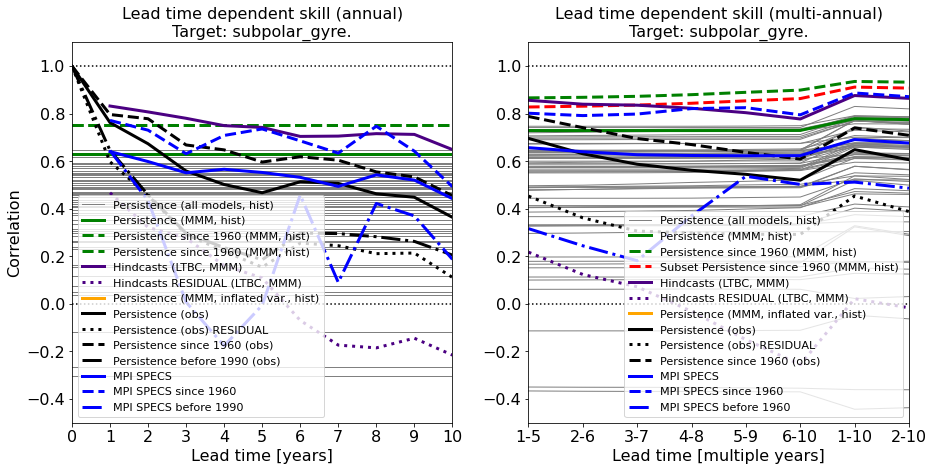

In [14]:
# =======================
# Compare analogue skill with baseline measures
# =======================

fontsize = 16
lw = 3
lead_times_multi = np.arange(len(start_lead))
labels_multi = ['-'.join([str(ss), str(ee)]) for ss, ee in zip(start_lead, end_lead)]

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
for imodel, model in enumerate(hist_models):
    if imodel == 0:
        label = 'Persistence (all models, hist)'
    else:
        label = None
    plt.plot(lead_times, historical_anom_ensmn_corr[imodel, :], color='grey', label=label, lw=1)

plt.plot(lead_times, historical_anom_ensmn_mmm_corr, color='green', label='Persistence (MMM, hist)', lw=lw)
plt.plot(lead_times, historical_anom_ensmn_mmm1960_corr, color='green', linestyle='--', label='Persistence since 1960 (MMM, hist)', lw=lw)
plt.plot(lead_times, historical_anom_ensmn_mmm1960_corr, color='green', linestyle='--', label='Persistence since 1960 (MMM, hist)', lw=lw)
plt.plot(lead_times, hindcast_time_series_ensmn_ltbc_mmm_corr, linestyle='-', color='indigo', label='Hindcasts (LTBC, MMM)', lw=lw)
plt.plot(lead_times, hindcast_time_series_ensmn_ltbc_mmm_res_corr, linestyle=':', color='indigo', label='Hindcasts RESIDUAL (LTBC, MMM)', lw=lw)
plt.plot(lead_times, historical_anom_inf_ensmn_mmm_corr, color='orange', label='Persistence (MMM, inflated var., hist)', lw=lw)
plt.plot(lead_times, persistence_corr, color='k', label='Persistence (obs)', lw=lw)
plt.plot(lead_times, persistence_res_corr, color='k', linestyle=':', label='Persistence (obs) RESIDUAL', lw=lw)
plt.plot(lead_times, persistence1960_corr, color='k', linestyle='--', label='Persistence since 1960 (obs)', lw=lw)
plt.plot(lead_times, persistence1990_corr, color='k', linestyle='-.', label='Persistence before 1990 (obs)', lw=lw)
plt.plot(lead_times, mpi_ensmn_corr, linestyle='-', color='blue', label='MPI SPECS', lw=lw)
plt.plot(lead_times, mpi_ensmn1960_corr, linestyle='--', color='blue', label='MPI SPECS since 1960', lw=lw)
plt.plot(lead_times, mpi_ensmn1990_corr, linestyle='-.', color='blue', label='MPI SPECS before 1990', lw=lw)
for num in [-1, 0, 1]:
    plt.axhline(num, linestyle=':', color='k')

plt.ylabel('Correlation', fontsize=fontsize)
plt.xlabel('Lead time [years]', fontsize=fontsize)
plt.xticks(np.arange(max_lead), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Lead time dependent skill (annual)\nTarget: {:s}.'.format(target_region), fontsize=fontsize)
plt.ylim(-0.5, 1.1)
plt.xlim(0, 10)
plt.legend(loc=0, fontsize=fontsize*0.7)

plt.subplot(1, 2, 2)
for imodel, model in enumerate(hist_models):
    if imodel == 0:
        label = 'Persistence (all models, hist)'
    else:
        label = None
    plt.plot(lead_times_multi, historical_anom_ensmn_multicorr[imodel, :], color='grey', label=label, lw=1)

plt.plot(lead_times_multi, historical_anom_ensmn_mmm_multicorr, color='green', label='Persistence (MMM, hist)', lw=lw)
plt.plot(lead_times_multi, historical_anom_ensmn_mmm1960_multicorr, color='green', linestyle='--', label='Persistence since 1960 (MMM, hist)', lw=lw)
plt.plot(lead_times_multi, historical_anom_ensmn_mmmsub1960_multicorr, color='red', linestyle='--', label='Subset Persistence since 1960 (MMM, hist)', lw=lw)
plt.plot(lead_times_multi, hindcast_time_series_ensmn_ltbc_mmm_multicorr, linestyle='-', color='indigo', label='Hindcasts (LTBC, MMM)', lw=lw)
plt.plot(lead_times_multi, hindcast_time_series_ensmn_ltbc_mmm_res_multicorr, linestyle=':', color='indigo', label='Hindcasts RESIDUAL (LTBC, MMM)', lw=lw)
plt.plot(lead_times_multi, historical_anom_inf_ensmn_mmm_multicorr, color='orange', label='Persistence (MMM, inflated var., hist)', lw=lw)
plt.plot(lead_times_multi, persistence_multicorr, color='k', label='Persistence (obs)', lw=lw)
plt.plot(lead_times_multi, persistence_res_multicorr, color='k', linestyle=':', label='Persistence (obs) RESIDUAL', lw=lw)
plt.plot(lead_times_multi, persistence1960_multicorr, color='k', linestyle='--', label='Persistence since 1960 (obs)', lw=lw)
plt.plot(lead_times_multi, mpi_ensmn_multicorr, linestyle='-', color='blue', label='MPI SPECS', lw=lw)
plt.plot(lead_times_multi, mpi_ensmn1960_multicorr, linestyle='--', color='blue', label='MPI SPECS since 1960', lw=lw)
plt.plot(lead_times_multi, mpi_ensmn1990_multicorr, linestyle='-.', color='blue', label='MPI SPECS before 1960', lw=lw)
for num in [-1, 0, 1]:
    plt.axhline(num, linestyle=':', color='k')

# plt.ylabel('Correlation', fontsize=fontsize)
plt.xlabel('Lead time [multiple years]', fontsize=fontsize)
plt.xticks(np.arange(8), fontsize=fontsize)
plt.gca().set_xticklabels(labels=labels_multi)
plt.yticks(fontsize=fontsize)
plt.title('Lead time dependent skill (multi-annual)\nTarget: {:s}.'.format(target_region), fontsize=fontsize)
plt.ylim(-0.5, 1.1)
plt.xlim(0, len(start_lead)-1)
plt.legend(loc=0, fontsize=fontsize*0.7)

fig_save_file = '{:s}HistoricalAnalogues_InvestigateHindcastSkill_{:s}_TARGET{:s}_LTDS.png'.format(figure_dir, var, target_region)
print(fig_save_file)
plt.savefig(fig_save_file, bbox_inches = 'tight')

# TODO: Add some kind of statistical  significance curve assuming independent

In [15]:
# =======================
# Save the baseline measures for use elsewhere
# =======================
baseline_save_file = '{:s}/Analogues_{:s}_BaselineSkillMeasures_{:s}.pkl'.format(data_dir, var, target_region)
with open(baseline_save_file, 'wb') as handle:
    print('Writing to {:s}'.format(baseline_save_file))
    data = {}
    data['lead_times'] = lead_times
    data['hist_models'] = hist_models
    data['hind_models'] = hind_models
    data['historical_mmm'] = historical_time_series_anom_ensmn_mmm
    data['historical_anom_ensmn_corr'] = historical_anom_ensmn_corr
    data['historical_anom_ensmn_mmm_corr'] = historical_anom_ensmn_mmm_corr
    data['historical_anom_ensmn_mmm1960_corr'] = historical_anom_ensmn_mmm1960_corr
    data['historical_anom_ensmn_mmm1990_corr'] = historical_anom_ensmn_mmm1990_corr
    data['hindcast_time_series_ensmn_mmm_corr'] = hindcast_time_series_ensmn_mmm_corr
    data['hindcast_time_series_ensmn_ltbc_mmm_corr'] = hindcast_time_series_ensmn_ltbc_mmm_corr
    data['hindcast_time_series_ensmn_ltbc_mmm5_corr'] = hindcast_time_series_ensmn_ltbc_mmm5_corr
    data['hindcast_time_series_ensmn_ltbc_mmm6_corr'] = hindcast_time_series_ensmn_ltbc_mmm6_corr
    data['historical_anom_inf_ensmn_mmm_corr'] = historical_anom_inf_ensmn_mmm_corr
    data['persistence_corr'] = persistence_corr
    data['persistence_res_corr'] = persistence_res_corr
    data['persistence1960_corr'] = persistence1960_corr
    data['persistence1990_corr'] = persistence1990_corr
    data['persistence_smoothed_corr'] = persistence_smoothed_corr
    data['historical_anom_ensmn_multicorr'] = historical_anom_ensmn_multicorr
    data['historical_anom_ensmn_mmm_multicorr'] = historical_anom_ensmn_mmm_multicorr
    data['historical_anom_ensmn_mmm1960_multicorr'] = historical_anom_ensmn_mmm1960_multicorr
    data['historical_anom_ensmn_mmmsub_multicorr'] = historical_anom_ensmn_mmmsub_multicorr
    data['historical_anom_ensmn_mmmsub1960_multicorr'] = historical_anom_ensmn_mmmsub1960_multicorr
    data['hindcast_time_series_ensmn_mmm_multicorr'] = hindcast_time_series_ensmn_mmm_multicorr
    data['hindcast_time_series_ensmn_ltbc_mmm_multicorr'] = hindcast_time_series_ensmn_ltbc_mmm_multicorr
    data['hindcast_time_series_ensmn_ltbc_mmm5_multicorr'] = hindcast_time_series_ensmn_ltbc_mmm5_multicorr
    data['hindcast_time_series_ensmn_ltbc_mmm6_multicorr'] = hindcast_time_series_ensmn_ltbc_mmm6_multicorr
    data['historical_anom_inf_ensmn_mmm_multicorr'] = historical_anom_inf_ensmn_mmm_multicorr
    data['persistence_multicorr'] = persistence_multicorr
    data['persistence_res_multicorr'] = persistence_res_multicorr
    data['persistence1960_multicorr'] = persistence1960_multicorr
    data['persistence_smoothed_multicorr'] = persistence_smoothed_multicorr
    data['mpi_ensmn_corr'] = mpi_ensmn_corr
    data['mpi_ensmn1960_corr'] = mpi_ensmn1960_corr
    data['mpi_ensmn1990_corr'] = mpi_ensmn1990_corr
    data['mpi_ensmn_multicorr'] = mpi_ensmn_multicorr
    data['mpi_ensmn1960_multicorr'] = mpi_ensmn1960_multicorr
    data['mpi_ensmn1990_multicorr'] = mpi_ensmn1990_multicorr
    data['hindcast_time_series_ensmn_ltbc_mmm'] = hindcast_time_series_ensmn_ltbc_mmm
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(" ++ Complete")

Writing to /home/users/lfbor/data/Analogues_SST_BaselineSkillMeasures_subpolar_gyre.pkl
 ++ Complete
